# Sentiment Analysis

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

#try:
#  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
#  device = torch.device("cuda")
#except ValueError:
 # raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

#tf.config.experimental_connect_to_cluster(tpu)
#tf.tpu.experimental.initialize_tpu_system(tpu)
#tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)


import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Tensorflow version 2.4.1
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## Import Library

In [2]:
import pandas as pd #Analysis 
import matplotlib.pyplot as plt #Visulization
import seaborn as sns #Visulization
import numpy as np #Analysis 
from scipy.stats import norm #Analysis 
from sklearn.preprocessing import StandardScaler #Analysis 
from scipy import stats #Analysis 
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
import gc

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
nltk.download("stopwords")
nltk.download('vader_lexicon')

import os
import string
color = sns.color_palette()

%matplotlib inline

from plotly import tools,subplots
import plotly.offline as py 
from plotly.offline import iplot,init_notebook_mode
py.init_notebook_mode(connected=False)
import plotly.graph_objs as go
from IPython.display import Image
#import plotly.io as pio
#pio.renderers.default="chrome"
from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


## Load Dataset

In [3]:
df_train = pd.read_csv("/content/drive/MyDrive/NLP_Prj/drugsComTrain_raw.csv", parse_dates=["date"])
df_test = pd.read_csv("/content/drive/MyDrive/NLP_Prj/drugsComTest_raw 2.csv", parse_dates=["date"])

In [4]:
df_all = pd.concat([df_train,df_test])

In [5]:
df_all #215063 records

uniqueID                  drugName                     condition  \
0        206461                 Valsartan  Left Ventricular Dysfunction   
1         95260                Guanfacine                          ADHD   
2         92703                    Lybrel                 Birth Control   
3        138000                Ortho Evra                 Birth Control   
4         35696  Buprenorphine / naloxone             Opiate Dependence   
...         ...                       ...                           ...   
53761    159999                 Tamoxifen     Breast Cancer, Prevention   
53762    140714              Escitalopram                       Anxiety   
53763    130945            Levonorgestrel                 Birth Control   
53764     47656                Tapentadol                          Pain   
53765    113712                 Arthrotec                      Sciatica   

                                                  review  rating       date  \
0      "It has no side effect, I take it in combinati...       9 2012-05-20   
1      "My son is halfway through his fourth week of ...       8 2010-04-27   
2      "I used to take another oral contraceptive, wh...       5 2009-12-14   
3      "This is my first time using any form of birth...       8 2015-11-03   
4      "Suboxone has completely turned my life around...       9 2016-11-27   
...                                                  ...     ...        ...   
53761  "I have taken Tamoxifen for 5 years. Side effe...      10 2014-09-13   
53762  "I&#039;ve been taking Lexapro (escitaploprgra...       9 2016-10-08   
53763  "I&#039;m married, 34 years old and I have no ...       8 2010-11-15   
53764  "I was prescribed Nucynta for severe neck/shou...       1 2011-11-28   
53765                                      "It works!!!"       9 2009-09-13   

       usefulCount  
0               27  
1              192  
2               17  
3               10  
4               37  
...            ...  
53761           43  
53762           11  
53763            7  
53764           20  
53765           46  

[215063 rows x 7 columns]

## Exploratory Data Analysis

Text(0.5, 1.0, 'Top20 : The number of drugs per condition.')

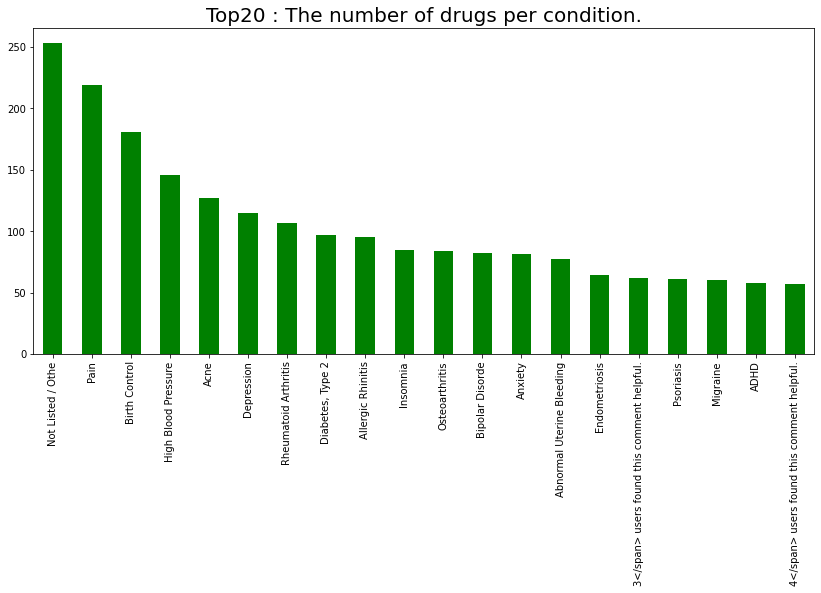

In [8]:
condition_dn = df_all.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
condition_dn[0:20].plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Top20 : The number of drugs per condition.", fontsize = 20)

Text(0.5, 1.0, 'Bottom20 : The number of drugs per condition.')

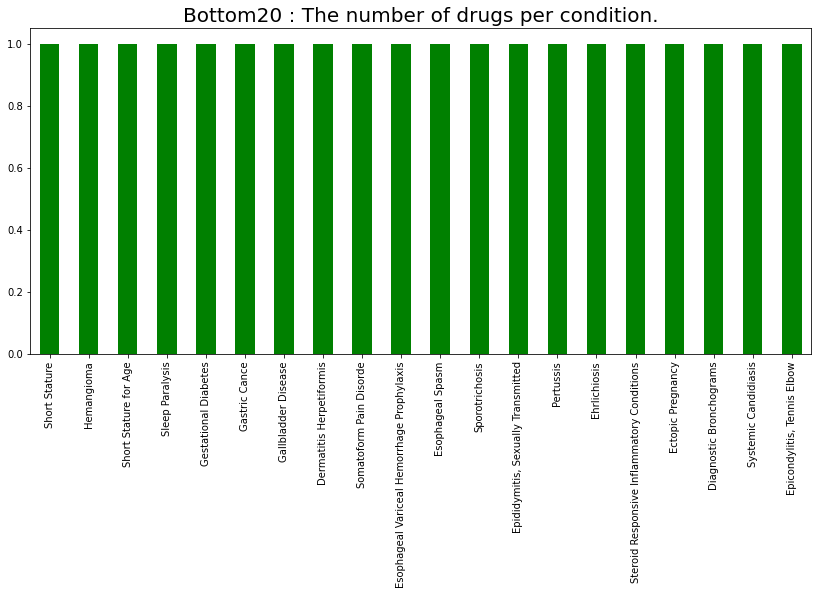

In [9]:
df_all[df_all['condition']=='3</span> users found this comment helpful.'].head(3)
condition_dn = df_all.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)

condition_dn[condition_dn.shape[0]-20:condition_dn.shape[0]].plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Bottom20 : The number of drugs per condition.", fontsize = 20)

Text(0.5, 1.0, 'Top10 : The number of reviews per condition.')

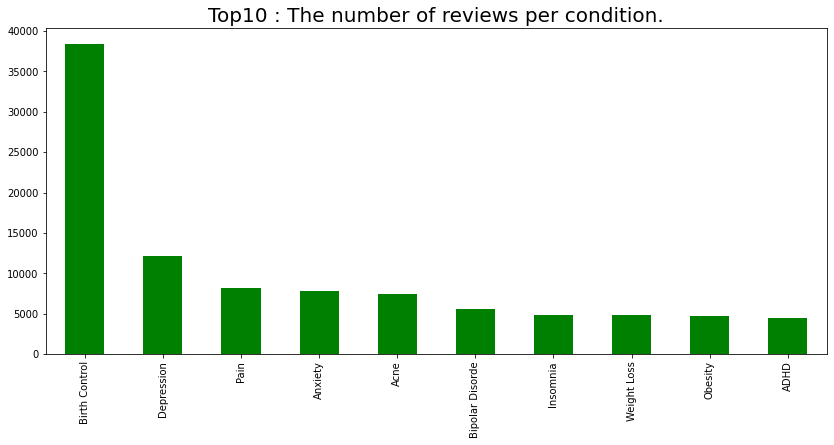

In [10]:
drug_using_count=df_all.groupby('condition')['drugName'].count().sort_values(ascending=False)
drug_using_count[0:10].plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Top10 : The number of reviews per condition.", fontsize = 20)

Text(0.5, 1.0, 'Number of Reviews for Different Ratings')

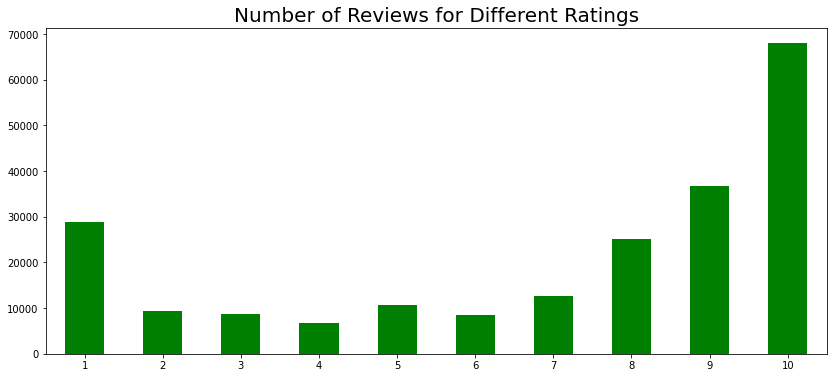

In [11]:
rating = df_all['rating'].value_counts().reset_index(name='count').sort_values(by=['index'],ascending=True)
rating
rating.plot(kind="bar",x='index',y='count', figsize = (14,6), fontsize = 10,color="green", legend=None)
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.xticks(rotation=0)
plt.title("Number of Reviews for Different Ratings", fontsize = 20)

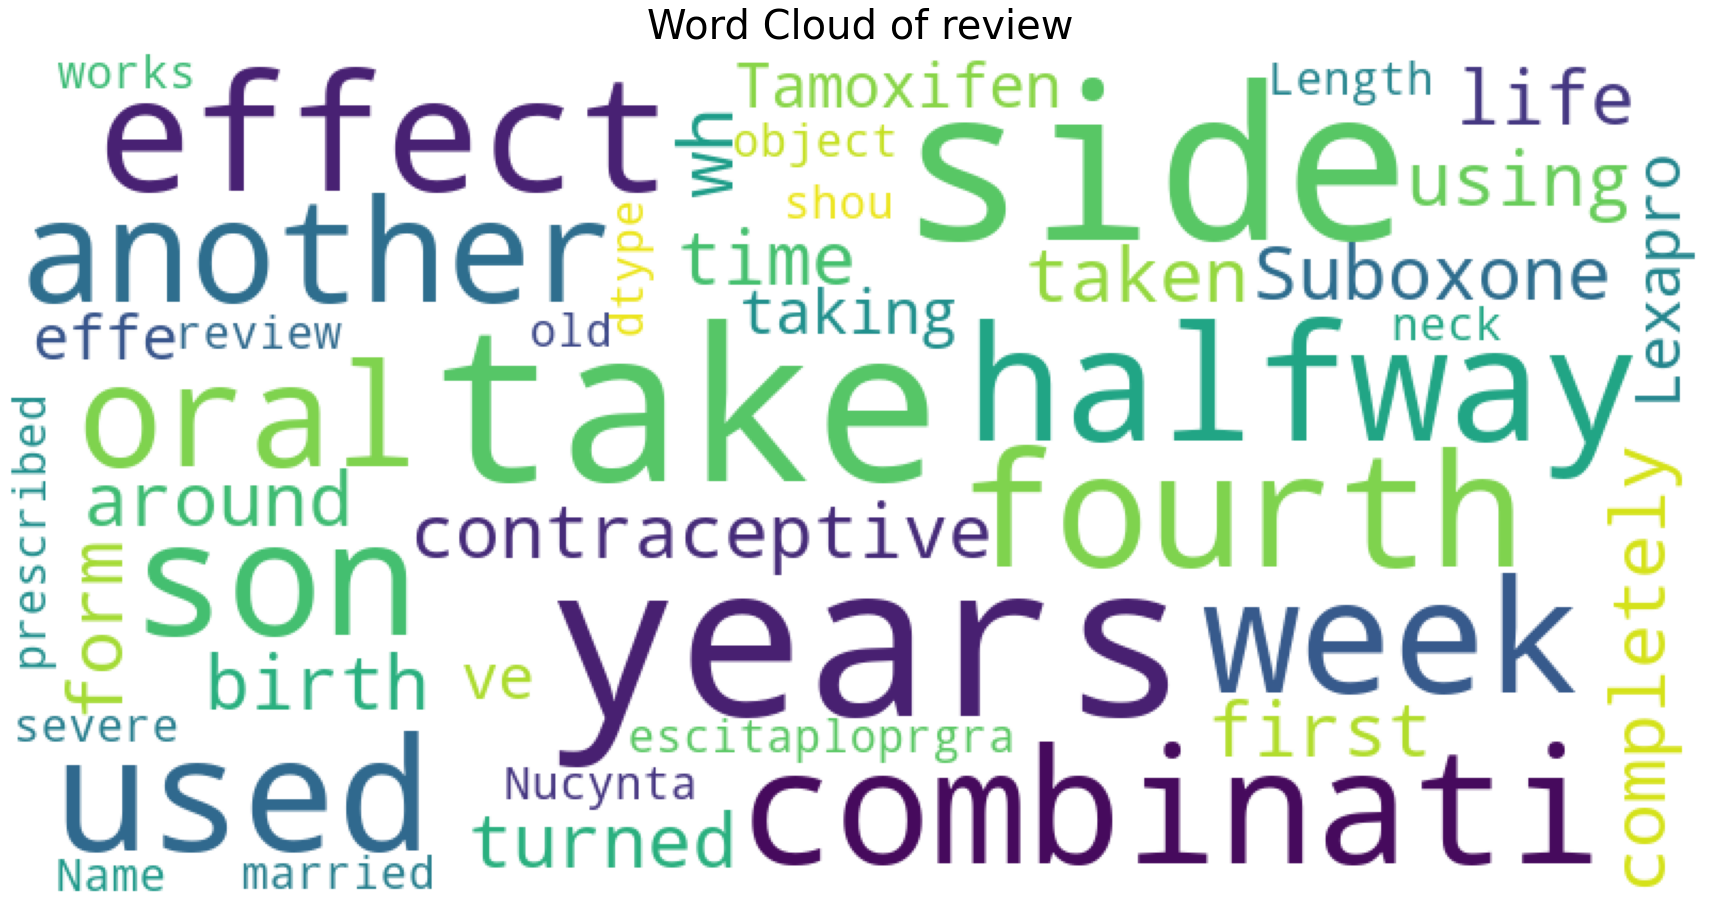

In [12]:
from wordcloud import WordCloud, STOPWORDS

def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(df_all["review"], title="Word Cloud of review")

In [11]:
from collections import defaultdict
df_all_6_10 = df_all[df_all["rating"]>5]
df_all_1_5 = df_all[df_all["rating"]<6]

In [12]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace
configure_plotly_browser_state()

## Get the bar chart from rating  8 to 10 review ##
freq_dict = defaultdict(int)
for sent in df_all_1_5["review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

## Get the bar chart from rating  4 to 7 review ##
freq_dict = defaultdict(int)
for sent in df_all_6_10["review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of rating 1 to 5", 
                                          "Frequent words of rating 6 to 10"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

/usr/local/lib/python3.7/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [13]:
configure_plotly_browser_state()


freq_dict = defaultdict(int)
for sent in df_all_1_5["review"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

freq_dict = defaultdict(int)
for sent in df_all_6_10["review"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent biagrams of rating 1 to 5", 
                                          "Frequent biagrams of rating 6 to 10"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig['layout'].update(height=1200, width=1000, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

/usr/local/lib/python3.7/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [14]:
configure_plotly_browser_state()

freq_dict = defaultdict(int)
for sent in df_all_1_5["review"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'green')

freq_dict = defaultdict(int)
for sent in df_all_6_10["review"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(50), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent trigrams of rating 1 to 5", 
                                          "Frequent trigrams of rating 6 to 10"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig['layout'].update(height=1200, width=1600, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
py.iplot(fig, filename='word-plots')

/usr/local/lib/python3.7/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [15]:
configure_plotly_browser_state()

freq_dict = defaultdict(int)
for sent in df_all_1_5["review"]:
    for word in generate_ngrams(sent,4):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'red')

freq_dict = defaultdict(int)
for sent in df_all_6_10["review"]:
    for word in generate_ngrams(sent,4):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(50), 'red')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent 4-grams of rating 1 to 5", 
                                          "Frequent 4-grams of rating 6 to 10"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig['layout'].update(height=1200, width=1600, paper_bgcolor='rgb(233,233,233)', title="4-grams Count Plots")
py.iplot(fig, filename='word-plots')

/usr/local/lib/python3.7/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



Text(0.5, 1.0, 'Count of rating values')

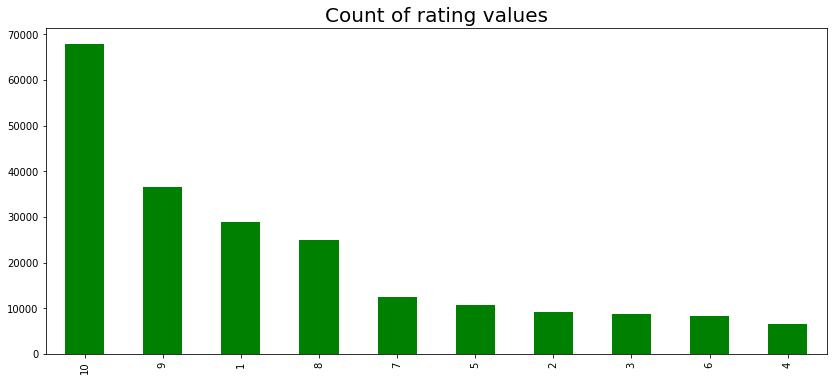

In [16]:
rating = df_all['rating'].value_counts().sort_values(ascending=False)
rating.plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Count of rating values", fontsize = 20)

Text(0.5, 1.0, 'Mean rating in year')

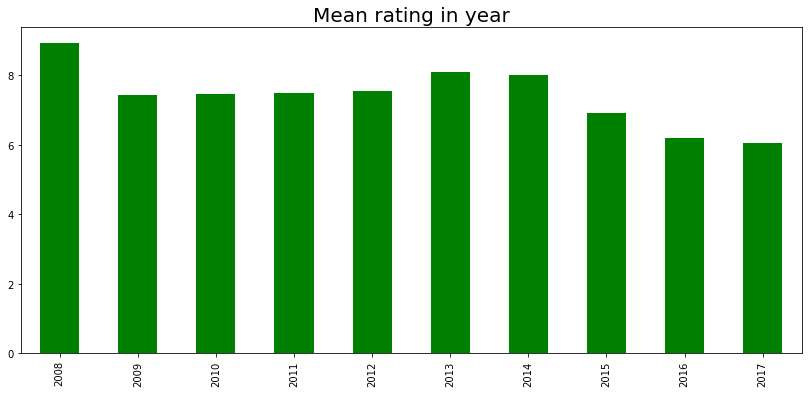

In [17]:
df_all['year'] = df_all['date'].dt.year
rating = df_all.groupby('year')['rating'].mean()
rating.plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Mean rating in year", fontsize = 20)

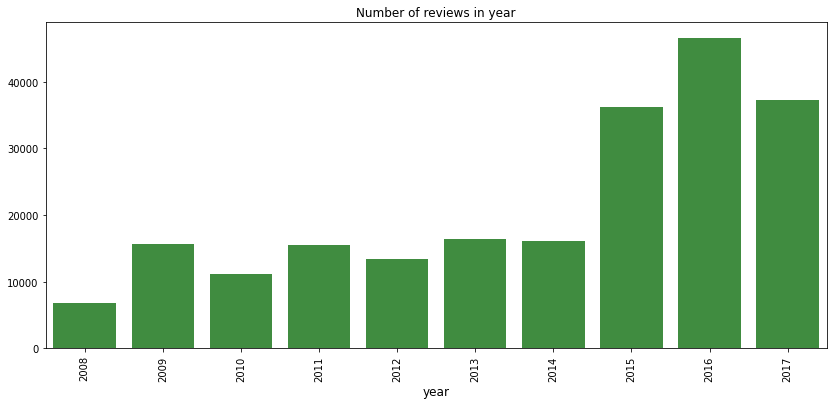

In [18]:
cnt_srs = df_all['date'].dt.year.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('year', fontsize=12)
plt.ylabel('', fontsize=12)
plt.title("Number of reviews in year")
plt.show()


Text(0.5, 1.0, 'Total Missing Value ')

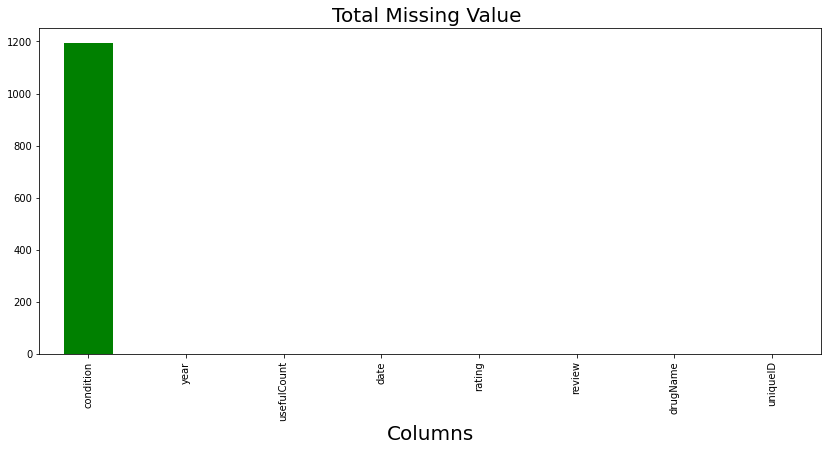

In [19]:
percent = (df_all.isnull().sum()).sort_values(ascending=False)
percent.plot(kind="bar", figsize = (14,6), fontsize = 10, color='green')
plt.xlabel("Columns", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Total Missing Value ", fontsize = 20)

In [20]:
df_train = df_train.dropna(axis=0)
df_test = df_test.dropna(axis=0)

Text(0.5, 1.0, 'Total Missing Value ')

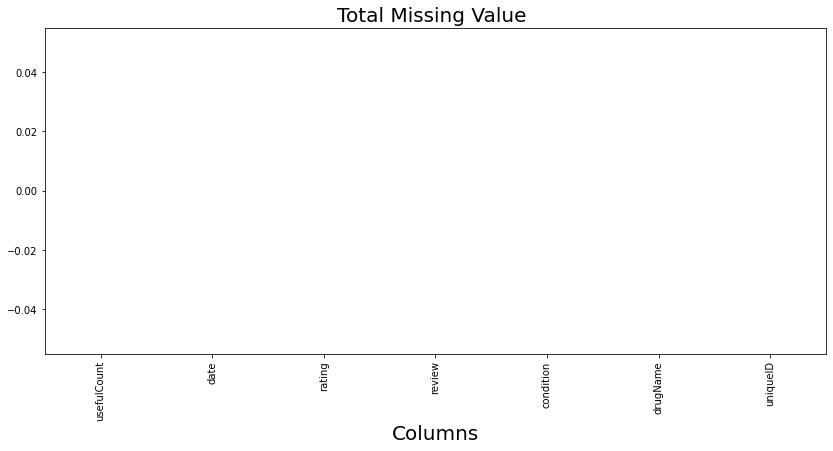

In [21]:
df_all = pd.concat([df_train,df_test]).reset_index()
del df_all['index']
percent = (df_all.isnull().sum()).sort_values(ascending=False)
percent.plot(kind="bar", figsize = (14,6), fontsize = 10, color='green')
plt.xlabel("Columns", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Total Missing Value ", fontsize = 20)

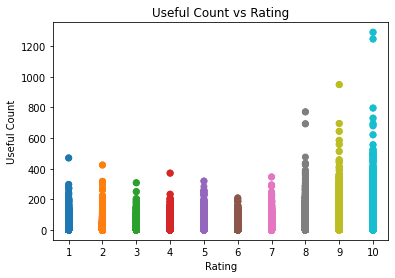

In [22]:
# Is rating correlated with usefulness of the review?
plt.scatter(df_all.rating, df_all.usefulCount, c=df_all.rating.values, cmap='tab10')
plt.title('Useful Count vs Rating')
plt.xlabel('Rating')
plt.ylabel('Useful Count')
plt.xticks([i for i in range(1, 11)]);

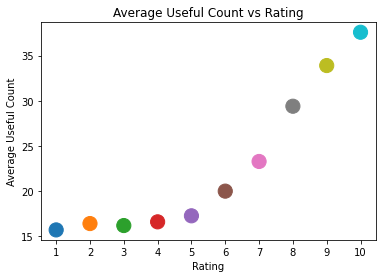

In [23]:
# Create a list (cast into an array) containing the average usefulness for given ratings
use_ls = []

for i in range(1, 11):
    use_ls.append([i, np.sum(df_all[df_all.rating == i].usefulCount) / np.sum([df_all.rating == i])])
    
use_arr = np.asarray(use_ls)

plt.scatter(use_arr[:, 0], use_arr[:, 1], c=use_arr[:, 0], cmap='tab10', s=200)
plt.title('Average Useful Count vs Rating')
plt.xlabel('Rating')
plt.ylabel('Average Useful Count')
plt.xticks([i for i in range(1, 11)]);

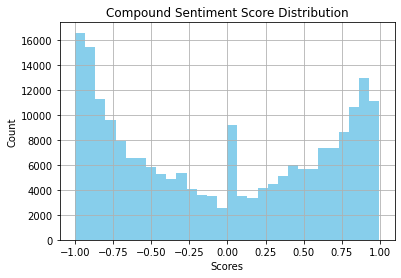

In [24]:
sid = SentimentIntensityAnalyzer()
useful_train = df_all.sort_values(by='usefulCount', ascending=False)

# Create list (cast to array) of compound polarity sentiment scores for reviews
sentiments = []

for i in df_all.review:
    sentiments.append(sid.polarity_scores(i).get('compound'))
    
sentiments = np.asarray(sentiments)

useful_train['sentiment'] = pd.Series(data=sentiments)
useful_train = useful_train.reset_index(drop=True)

useful_train.sentiment.hist(color='skyblue', bins=30)
plt.title('Compound Sentiment Score Distribution')
plt.xlabel('Scores')
plt.ylabel('Count');

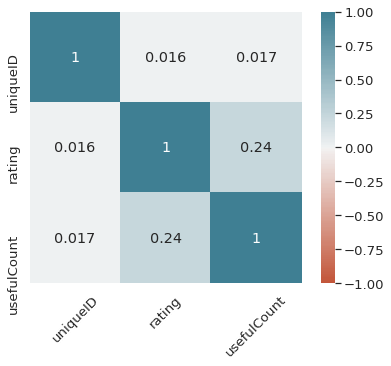

In [25]:
# Heatmap of the correlation matrix
plt.rcParams['figure.figsize'] = [7,5]
sns.set(font_scale = 1.2)
corr = df_all.select_dtypes(include = 'int64').corr()
sns_heat = sns.heatmap(corr, annot = True, vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200), square=True);
plt.setp(sns_heat.get_xticklabels(), rotation = 45);

## Preprocessing

In [26]:
all_list = set(df_all.index)
span_list = []
for i,j in enumerate(df_all['condition']):
    if '</span>' in j:
        span_list.append(i)


new_idx = all_list.difference(set(span_list))
df_all = df_all.iloc[list(new_idx)].reset_index()
del df_all['index']


df_condition = df_all.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
df_condition = pd.DataFrame(df_condition).reset_index()
df_condition.tail(20)

df_condition_1 = df_condition[df_condition['drugName']==1].reset_index()


all_list = set(df_all.index)
condition_list = []
for i,j in enumerate(df_all['condition']):
    for c in list(df_condition_1['condition']):
        if j == c:
            condition_list.append(i)
            
new_idx = all_list.difference(set(condition_list))
df_all = df_all.iloc[list(new_idx)].reset_index()
del df_all['index']

In [27]:

stops = set(stopwords.words('english'))

not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stops.remove(i)



In [28]:
from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
from bs4 import BeautifulSoup
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn import metrics
!pip install keras
!pip install tensorflow
#print(keras.__version__)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#from tensorflow.keras.layers import LSTM, CuDNNLSTM
from tensorflow.python.keras.layers import LSTM, CuDNNLSTM


from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [29]:
stemmer = SnowballStemmer('english')

def review_to_words(raw_review):
    # 1. Delete HTML 
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 5. Stopwords 
    meaningful_words = [w for w in words if not w in stops]
    # 6. Stemming
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 7. space join words
    return( ' '.join(stemming_words))

In [30]:
%time df_all['review_clean'] = df_all['review'].apply(review_to_words)
#%time df_train['review_clean'] = df_train['review'].apply(review_to_words)
#%time df_test['review_clean'] = df_test['review'].apply(review_to_words)

CPU times: user 2min 12s, sys: 764 ms, total: 2min 13s
Wall time: 2min 13s


In [31]:
df_train

uniqueID                  drugName                     condition  \
0         206461                 Valsartan  Left Ventricular Dysfunction   
1          95260                Guanfacine                          ADHD   
2          92703                    Lybrel                 Birth Control   
3         138000                Ortho Evra                 Birth Control   
4          35696  Buprenorphine / naloxone             Opiate Dependence   
...          ...                       ...                           ...   
161292    191035                   Campral            Alcohol Dependence   
161293    127085            Metoclopramide               Nausea/Vomiting   
161294    187382                   Orencia          Rheumatoid Arthritis   
161295     47128        Thyroid desiccated           Underactive Thyroid   
161296    215220              Lubiprostone         Constipation, Chronic   

                                                   review  rating       date  \
0       "It has no side effect, I take it in combinati...       9 2012-05-20   
1       "My son is halfway through his fourth week of ...       8 2010-04-27   
2       "I used to take another oral contraceptive, wh...       5 2009-12-14   
3       "This is my first time using any form of birth...       8 2015-11-03   
4       "Suboxone has completely turned my life around...       9 2016-11-27   
...                                                   ...     ...        ...   
161292  "I wrote my first report in Mid-October of 201...      10 2015-05-31   
161293  "I was given this in IV before surgey. I immed...       1 2011-11-01   
161294  "Limited improvement after 4 months, developed...       2 2014-03-15   
161295  "I&#039;ve been on thyroid medication 49 years...      10 2015-09-19   
161296  "I&#039;ve had chronic constipation all my adu...       9 2014-12-13   

        usefulCount  
0                27  
1               192  
2                17  
3                10  
4                37  
...             ...  
161292          125  
161293           34  
161294           35  
161295           79  
161296          116  

[160398 rows x 7 columns]

Split into train and test data

In [32]:
df_all['sentiment'] = df_all["rating"].apply(lambda x: 1 if x > 5 else 0)
#df_train['sentiment'] = df_train["rating"].apply(lambda x: 1 if x > 5 else 0)
#df_test['sentiment'] = df_test["rating"].apply(lambda x: 1 if x > 5 else 0)

df_train, df_test = train_test_split(df_all, test_size=0.33, random_state=42) 


In [33]:
df_train

uniqueID         drugName                    condition  \
130185     66913         Seroquel  Generalized Anxiety Disorde   
155501    222222      Fluconazole       Onychomycosis, Toenail   
75325      75807        Temazepam                     Insomnia   
19174     229747         Ketamine                         Pain   
209735    102495     Aripiprazole     Major Depressive Disorde   
...          ...              ...                          ...   
119879    147556       Alprazolam                      Anxiety   
103694    221534           Makena                Premature Lab   
131932    221729  Dexlansoprazole          Erosive Esophagitis   
146867    149934             Soma         Nocturnal Leg Cramps   
121958     45856  Phendimetrazine                      Obesity   

                                                   review  rating       date  \
130185  "After trying nearly every SSRI on the market ...       9 2010-11-26   
155501  "This takes 6+ months, but did clear up a deca...       9 2008-05-03   
75325   "Worked for awhile pretty well but then went b...       2 2016-04-21   
19174   "I was given this after surgery for pain as I ...       1 2016-04-16   
209735  "Abilify served me well over a two month perio...       9 2016-12-16   
...                                                   ...     ...        ...   
119879  "Love it. It made me really relaxed/calm and s...      10 2009-07-14   
103694  "I had two of my boys at 34 wks and one at 29 ...      10 2017-07-07   
131932  "Had severe chest pain, but knew it wasn&#039;...       9 2011-05-23   
146867  "This medicine is a God-send! For years I stru...      10 2013-05-28   
121958  "I started taking the Medicine exactly one wee...       9 2015-09-01   

        usefulCount                                       review_clean  \
130185          102  tri near everi ssri market place pristiq impro...   
155501           39                 take month clear decad long infect   
75325            15  work awhil pretti well went back mayb get hour...   
19174            19  given surgeri pain morphin tri drug sort omg w...   
209735            5  abilifi serv well two month period antidepress...   
...             ...                                                ...   
119879           30         love made realli relax calm still abl work   
103694            9  two boy wks one wks start makena inject wks pr...   
131932           33  sever chest pain knew heart endoscop show duod...   
146867          119  medicin god send year struggl restless leg hyp...   
121958           28  start take medicin exact one week today weigh ...   

        sentiment  
130185          1  
155501          1  
75325           0  
19174           0  
209735          1  
...           ...  
119879          1  
103694          1  
131932          1  
146867          1  
121958          1  

[142075 rows x 9 columns]

In [34]:
df_test

uniqueID                          drugName  \
147354    126702                       Brimonidine   
195249     84765  Ethinyl estradiol / norgestimate   
86265      71559                           Vraylar   
44172     132320                            Ativan   
90569     177278                        Duloxetine   
...          ...                               ...   
127553    216906                       Lifitegrast   
45442     141240                      Escitalopram   
148240     54801            Bupropion / naltrexone   
175071    101255                             Aubra   
200011     26484                          Sprintec   

                          condition  \
147354                      Rosacea   
195249                Birth Control   
86265               Bipolar Disorde   
44172                       Anxiety   
90569   Generalized Anxiety Disorde   
...                             ...   
127553              Dry Eye Disease   
45442                    Depression   
148240                  Weight Loss   
175071                Birth Control   
200011    Abnormal Uterine Bleeding   

                                                   review  rating       date  \
147354  "Never , never , never use this cream !!!!!! I...       1 2015-08-31   
195249  "I was switched to this after about 9 months o...      10 2016-05-01   
86265   "I began at 1.5 then titrated to 3mg dosage. A...       3 2016-08-17   
44172   "Ativan 0.5mg calms me down considerably withi...       5 2012-01-12   
90569   "My thoughts on Cymbalta: Cymbalta has left me...       1 2017-05-03   
...                                                   ...     ...        ...   
127553  "I had no initial problems with Xiidra. No bur...       1 2017-04-01   
45442   "Started out with 10 mg, stuck with it for pro...       7 2015-05-12   
148240  "I took the medicine for 2 weeks by taking 1 i...       1 2017-02-24   
175071  "This is my first birth control ever and I rea...      10 2017-06-30   
200011  "I&#039;ve been taking it for 2 months with no...      10 2014-10-20   

        usefulCount                                       review_clean  \
147354           17  never never never use cream help way angri dis...   
195249            3  switch month mononessa ask switch happen anywa...   
86265            17  began titrat mg dosag first love medicin compl...   
44172            26  ativan mg calm consider within minut side effe...   
90569            29  thought cymbalta cymbalta left fog no feel non...   
...             ...                                                ...   
127553           49  no initi problem xiidra no burn bad tast seem ...   
45442             8  start mg stuck probabl month entir time feel s...   
148240            7  took medicin week take morn anoth one night lo...   
175071            0  first birth control ever realli love use horri...   
200011            8             take month no issu also cramp not pain   

        sentiment  
147354          0  
195249          1  
86265           0  
44172           0  
90569           0  
...           ...  
127553          0  
45442           1  
148240          0  
175071          1  
200011          1  

[69978 rows x 9 columns]

**Count Vectorizer**

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

vectorizer = CountVectorizer(analyzer = 'word', 
                             tokenizer = None,
                             preprocessor = None, 
                             stop_words = None, 
                             min_df = 2, #Minimum number of documents for token to appear
                             ngram_range=(4, 4),
                             max_features = 20000
                            )
vectorizer = CountVectorizer(binary=True, stop_words=stopwords.words('english'),lowercase=True, max_features=5000)
vectorizer

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=5000, min_df=1,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

Create array of cleaned review texts

In [36]:
X_train=(df_train['review_clean'].to_numpy())
X_test=(df_test['review_clean'].to_numpy())

Fit and Transform CountVectorizer

In [37]:
import scipy 
stop_words = vectorizer.get_stop_words()
test_train = np.concatenate([X_train, X_test])
X_onehot = vectorizer.fit_transform(test_train)
xtrain_onehot=vectorizer.fit_transform(X_train)
xtest_onehot=vectorizer.fit_transform(X_test)

#print(type(X_onehot))

X_onehot1=scipy.sparse.csr_matrix(X_onehot)
xtrain_onehot1=scipy.sparse.csr_matrix(xtrain_onehot)
xtest_onehot1=scipy.sparse.csr_matrix(xtest_onehot)


**Fit and Transform TD-IDF vectorizer**

In [38]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(binary=True, stop_words=stopwords.words('english'),lowercase=True, max_features=5000)

tf_idf_X_onehot = tfidf_vectorizer.fit_transform(test_train)
tf_idf_xtrain_onehot=tfidf_vectorizer.fit_transform(X_train)
tf_idf_xtest_onehot=tfidf_vectorizer.fit_transform(X_test)

#print(type(X_onehot))

tf_idf_X_onehot1=scipy.sparse.csr_matrix(tf_idf_X_onehot)
tf_idf_xtrain_onehot1=scipy.sparse.csr_matrix(tf_idf_xtrain_onehot)
tf_idf_xtest_onehot1=scipy.sparse.csr_matrix(tf_idf_xtest_onehot)


convert sparse matrix to sparse tensor

In [39]:
import tensorflow as tf
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape))

X_onehot2=convert_sparse_matrix_to_sparse_tensor(xtrain_onehot1) # this is working 
X_onehot3=convert_sparse_matrix_to_sparse_tensor(tf_idf_xtrain_onehot1)
y_onehot2=convert_sparse_matrix_to_sparse_tensor(xtest_onehot1) # this is working 
y_onehot3=convert_sparse_matrix_to_sparse_tensor(tf_idf_xtest_onehot1) # this is working 


In [40]:
print('y_onehot2',y_onehot2.shape)
print('y_onehot3',y_onehot3.shape)
#print(X_onehot1.get_shape())
#print(y_onehot)

print('X_onehot2',X_onehot2.shape)
print('X_onehot3',X_onehot3.shape)

print(type(y_onehot2))


y_onehot2 (69978, 5000)
y_onehot3 (69978, 5000)
X_onehot2 (142075, 5000)
X_onehot3 (142075, 5000)
<class 'tensorflow.python.framework.sparse_tensor.SparseTensor'>


Count Vectorizer - Pipeline

In [41]:
pipeline = Pipeline([
    ('vect', vectorizer),
])

%time train_data_features = pipeline.fit_transform(df_train['review_clean'])
%time test_data_features = pipeline.fit_transform(df_test['review_clean'])

CPU times: user 4.33 s, sys: 12.9 ms, total: 4.34 s
Wall time: 4.35 s
CPU times: user 2.13 s, sys: 3.95 ms, total: 2.14 s
Wall time: 2.14 s


TF-IDF Vectorizer - Pipeline

In [42]:

pipeline1 = Pipeline([
    ('vect1', tfidf_vectorizer),
])

%time  tfidf_train_data_features = pipeline1.fit_transform(df_train['review_clean'])
%time  tfidf_test_data_features = pipeline1.fit_transform(df_test['review_clean'])

CPU times: user 4.4 s, sys: 15 ms, total: 4.41 s
Wall time: 4.42 s
CPU times: user 2.2 s, sys: 8.98 ms, total: 2.2 s
Wall time: 2.21 s


**Word2Vec**

In [43]:
from gensim.models import Word2Vec

names_list = vectorizer.get_feature_names()
names_list1 = tfidf_vectorizer.get_feature_names()

#print(len(names_list),len(names_list1))
names = [[i] for i in names_list]
names1 = [[i] for i in names_list1]

names = Word2Vec(names, min_count=1)
names1 = Word2Vec(names1, min_count=1)

print(len(list(names.wv.vocab)))
print(list(names.wv.vocab)[:5])

5000
['aa', 'ab', 'abat', 'abdomen', 'abdomin']


## Model Build

### 1. Deep Neural Network

In [48]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
import random
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Bidirectional, LSTM, BatchNormalization, Dropout
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

# 1. Dataset
y_train = (df_train['sentiment'])
y_test = (df_test['sentiment'])
solution = y_test.copy()


#### Using Countvectorizer features

In [49]:

# 2. Model Structure
model = keras.models.Sequential()

model.add(keras.layers.Dense(200, input_dim=len(vectorizer.get_feature_names())))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(300))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

# 3. Model compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               1000200   
_________________________________________________________________
batch_normalization (BatchNo (None, 200)               800       
_________________________________________________________________
activation (Activation)      (None, 200)               0         
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               60300     
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
activation_1 (Activation)    (None, 300)               0

In [50]:
from keras.utils import to_categorical
def score_transform(X):
    #y_reshaped = np.reshape(X['rating'].values, (-1, 1))
    for index, val in enumerate(X['rating'].values):
        if val > 5:
            X['rating'][index] = 1
        #elif val >= 4:
         #   y_reshaped[index] = 2
        else:
            X['rating'][index] = 0
    X_result = to_categorical(X)
    return X_result
    
    print(X_onehot)

In [51]:
import io
import os
import re
import shutil
import string



y_train_test = pd.concat([df_train, df_test], ignore_index=True)
#y_train1 = score_transform(df_train)
#y_train1 = score_transform(df_train)
y_train1=df_train['sentiment'].to_numpy()
#y_train1=y_train.to_numpy()
#y_test1=y_test.to_numpy()

y_test1=df_test['sentiment'].to_numpy()

#y_test1=score_transform(df_test)
print(y_train1)
print(y_test1)
#y_train1=scipy.sparse.csr_matrix(y_train1)
#y_train1=convert_sparse_matrix_to_sparse_tensor(y_train1)
#print(type(y_train1))
#print(y_train1)

#print(X_onehot2)
print(type(X_onehot2.shape))
print(type(X_onehot3.shape))
print(X_onehot2.shape)
print(y_onehot3.shape)

#rint(type(X_onehot3.shape))

#print(np.max(y_test1))
print(y_train1.shape)
print(y_test1.shape)

[1 1 0 ... 1 1 1]
[0 1 0 ... 0 1 1]
<class 'tensorflow.python.framework.tensor_shape.TensorShape'>
<class 'tensorflow.python.framework.tensor_shape.TensorShape'>
(142075, 5000)
(69978, 5000)
(142075,)
(69978,)


In [104]:
# 4. Train model
import tensorflow.python.keras.backend as K 
sess = K.get_session()
#train_data = tf.data.Dataset.from_tensor_slices(y_train,y_test)
#print(train_data)
#tf.sparse.reorder(train_data_features)
#y_train1=tf.sparse.reorder(y_train1)
#tf.sparse.reorder(X_onehot,name=None)
#hist = model.fit(train_data_features1, y_train, epochs=10, batch_size=64)
hist = model.fit(X_onehot3, y_train1, epochs=20, batch_size=128,validation_data=(y_onehot3, y_test1))



Epoch 1/20
1110/1110 [==============================] - 23s 20ms/step - loss: 0.4797 - accuracy: 0.7736 - val_loss: 0.9589 - val_accuracy: 0.6862
Epoch 2/20
1110/1110 [==============================] - 21s 19ms/step - loss: 0.3500 - accuracy: 0.8457 - val_loss: 1.1438 - val_accuracy: 0.6833
Epoch 3/20
1110/1110 [==============================] - 21s 19ms/step - loss: 0.3098 - accuracy: 0.8653 - val_loss: 1.5824 - val_accuracy: 0.6783
Epoch 4/20
1110/1110 [==============================] - 21s 19ms/step - loss: 0.2685 - accuracy: 0.8856 - val_loss: 1.7884 - val_accuracy: 0.6780
Epoch 5/20
1110/1110 [==============================] - 21s 19ms/step - loss: 0.2275 - accuracy: 0.9049 - val_loss: 2.0826 - val_accuracy: 0.6761
Epoch 6/20
1110/1110 [==============================] - 21s 19ms/step - loss: 0.1931 - accuracy: 0.9217 - val_loss: 2.6079 - val_accuracy: 0.6745
Epoch 7/20
1110/1110 [==============================] - 21s 19ms/step - loss: 0.1711 - accuracy: 0.9318 - val_loss: 3.1228 -

In [114]:
from tensorflow.keras.utils import Sequence
loss_and_metrics = model.evaluate(y_onehot3, y_test1, batch_size=128)
loss, accuracy = model.evaluate(y_onehot2, y_test1, verbose=False)
loss_train, accuracy_train = model.evaluate(X_onehot3, y_train1, verbose=False)

print(loss_and_metrics)
print("Test Loss:  {:.4f}".format(loss))
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Train Loss:  {:.4f}".format(loss_train))
print("Train Accuracy:  {:.4f}".format(accuracy_train))

547/547 [==============================] - 6s 10ms/step - loss: 5.8295 - accuracy: 0.6796
[5.829537391662598, 0.6795850396156311]
Test Loss:  5.8295
Testing Accuracy:  0.6796
Train Loss:  0.0226
Train Accuracy:  0.9958


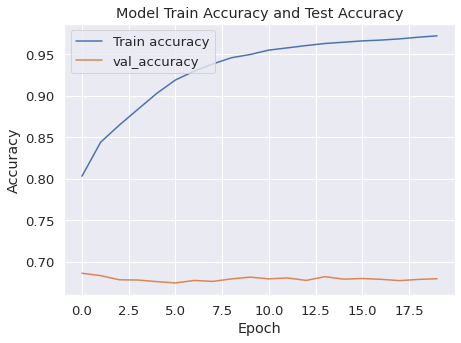

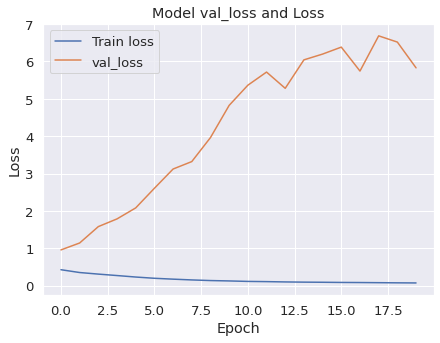

In [121]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Train Accuracy and Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'val_accuracy'], loc='upper left')
plt.show()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model val_loss and Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss','val_loss'], loc='upper left')
plt.show()

#### using TD-IDF vectorizer features

In [105]:
# 2. Model Structure
model1 = keras.models.Sequential()

model1.add(keras.layers.Dense(200, input_dim=len(tfidf_vectorizer.get_feature_names())))
model1.add(keras.layers.BatchNormalization())
model1.add(keras.layers.Activation('relu'))
model1.add(keras.layers.Dropout(0.5))

model1.add(keras.layers.Dense(300))
model1.add(keras.layers.BatchNormalization())
model1.add(keras.layers.Activation('relu'))
model1.add(keras.layers.Dropout(0.5))

model1.add(keras.layers.Dense(256, activation='relu'))
model1.add(keras.layers.Dense(1, activation='sigmoid'))

# 3. Model compile
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 200)               1000200   
_________________________________________________________________
batch_normalization_2 (Batch (None, 200)               800       
_________________________________________________________________
activation_2 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 300)               60300     
_________________________________________________________________
batch_normalization_3 (Batch (None, 300)               1200      
_________________________________________________________________
activation_3 (Activation)    (None, 300)              

In [106]:
hist1 = model1.fit(X_onehot3, y_train1, epochs=20, batch_size=128,validation_data=(y_onehot3, y_test1))


Epoch 1/20
1110/1110 [==============================] - 23s 20ms/step - loss: 0.4751 - accuracy: 0.7753 - val_loss: 0.9042 - val_accuracy: 0.6838
Epoch 2/20
1110/1110 [==============================] - 21s 19ms/step - loss: 0.3503 - accuracy: 0.8438 - val_loss: 1.2121 - val_accuracy: 0.6821
Epoch 3/20
1110/1110 [==============================] - 22s 19ms/step - loss: 0.3071 - accuracy: 0.8678 - val_loss: 1.5809 - val_accuracy: 0.6787
Epoch 4/20
1110/1110 [==============================] - 22s 20ms/step - loss: 0.2640 - accuracy: 0.8893 - val_loss: 2.0856 - val_accuracy: 0.6761
Epoch 5/20
1110/1110 [==============================] - 22s 20ms/step - loss: 0.2250 - accuracy: 0.9067 - val_loss: 2.4291 - val_accuracy: 0.6717
Epoch 6/20
1110/1110 [==============================] - 22s 20ms/step - loss: 0.1935 - accuracy: 0.9222 - val_loss: 3.0144 - val_accuracy: 0.6736
Epoch 7/20
1110/1110 [==============================] - 22s 20ms/step - loss: 0.1652 - accuracy: 0.9337 - val_loss: 3.3772 -

In [131]:
from tensorflow.keras.utils import Sequence
loss_and_metrics1 = model1.evaluate(y_onehot3, y_test1, batch_size=128)
loss1, accuracy1 = model1.evaluate(y_onehot2, y_test1, verbose=False)
loss_train1, accuracy_train1 = model1.evaluate(X_onehot3, y_train1, verbose=False)

print(loss_and_metrics1)

print("Test Loss:  {:.4f}".format(loss1))
print("Testing Accuracy:  {:.4f}".format(accuracy1))

print("Train Loss:  {:.4f}".format(loss_train1))
print("Train Accuracy:  {:.4f}".format(accuracy_train1))

547/547 [==============================] - 6s 12ms/step - loss: 5.9462 - accuracy: 0.6644
[5.946231842041016, 0.6643944978713989]
Test Loss:  5.9462
Testing Accuracy:  0.6644
Train Loss:  0.0218
Train Accuracy:  0.9953


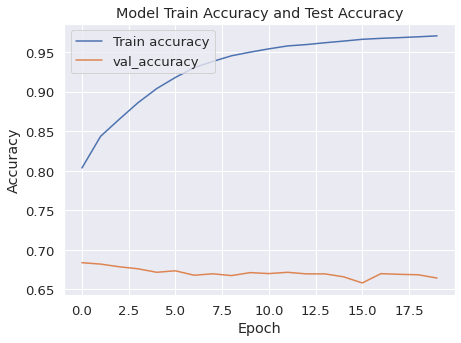

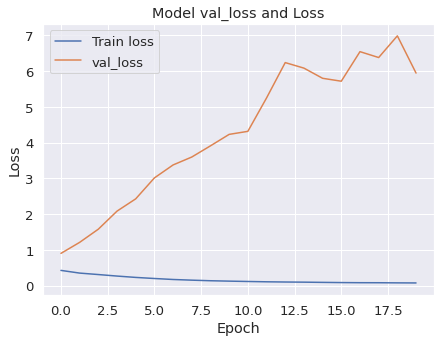

In [123]:
plt.plot(hist1.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])
plt.title('Model Train Accuracy and Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'val_accuracy'], loc='upper left')
plt.show()
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('Model val_loss and Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss','val_loss'], loc='upper left')
plt.show()

#### Try with Dropout, Regularizers for Count Vectorizer model

In [127]:
#Add Dropout 
from tensorflow.keras.regularizers import l1,l2
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights_d = dict(enumerate(class_weights))
model_reg_dp = Sequential()
model_reg_dp.add(Dense(256, input_dim=len(vectorizer.get_feature_names()), activation='relu',kernel_regularizer=l2(0.001)))
model_reg_dp.add(Dropout(0.01))
model_reg_dp.add(Dense(128, activation='relu',kernel_regularizer=l2(0.001)))
model_reg_dp.add(Dropout(0.01))
model_reg_dp.add(Dense(1, activation='sigmoid'))
model_reg_dp.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_reg_dp.summary()



#plot_history(hist_dp_reg)


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 256)               1280256   
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 129       
Total params: 1,313,281
Trainable params: 1,313,281
Non-trainable params: 0
_________________________________________________________________


In [140]:
hist_dp_reg = model_reg_dp.fit(X_onehot3, y_train1,epochs=20,batch_size=512,validation_data=(y_onehot3, y_test1))

Epoch 1/20
278/278 [==============================] - 7s 24ms/step - loss: 0.4167 - accuracy: 0.8472 - val_loss: 0.7918 - val_accuracy: 0.6542
Epoch 2/20
278/278 [==============================] - 7s 24ms/step - loss: 0.3941 - accuracy: 0.8666 - val_loss: 0.9098 - val_accuracy: 0.6636
Epoch 3/20
278/278 [==============================] - 7s 23ms/step - loss: 0.3806 - accuracy: 0.8819 - val_loss: 0.9487 - val_accuracy: 0.6620
Epoch 4/20
278/278 [==============================] - 7s 23ms/step - loss: 0.3637 - accuracy: 0.9000 - val_loss: 1.0631 - val_accuracy: 0.6345
Epoch 5/20
278/278 [==============================] - 7s 23ms/step - loss: 0.3493 - accuracy: 0.9147 - val_loss: 1.1986 - val_accuracy: 0.6683
Epoch 6/20
278/278 [==============================] - 7s 24ms/step - loss: 0.3279 - accuracy: 0.9272 - val_loss: 1.2362 - val_accuracy: 0.6381
Epoch 7/20
278/278 [==============================] - 7s 24ms/step - loss: 0.3130 - accuracy: 0.9372 - val_loss: 1.3394 - val_accuracy: 0.6470

In [141]:
loss_and_metrics2 = model_reg_dp.evaluate(y_onehot3, y_test1, batch_size=128)
loss2, accuracy2 = model_reg_dp.evaluate(y_onehot2, y_test1, verbose=False)
loss_train2, accuracy_train2 = model_reg_dp.evaluate(X_onehot3, y_train1, verbose=False)

print(loss_and_metrics2)
print("Test Loss:  {:.4f}".format(loss2))
print("Testing Accuracy:  {:.4f}".format(accuracy2))

print("Train Loss:  {:.4f}".format(loss_train2))
print("Train Accuracy:  {:.4f}".format(accuracy_train2))

547/547 [==============================] - 6s 10ms/step - loss: 1.8647 - accuracy: 0.6361
[1.8646728992462158, 0.6361427903175354]
Test Loss:  1.8647
Testing Accuracy:  0.6361
Train Loss:  0.2120
Train Accuracy:  0.9824


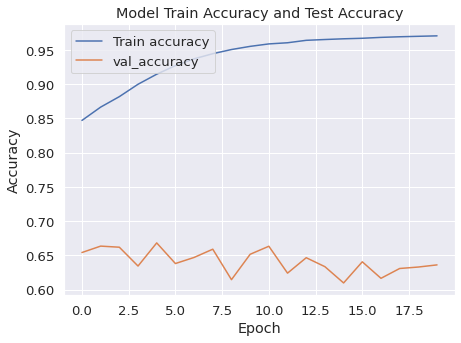

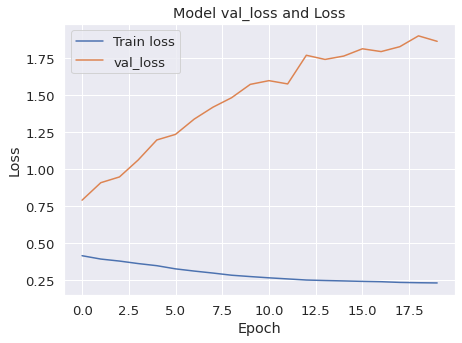

In [142]:

plt.plot(hist_dp_reg.history['accuracy'])
plt.plot(hist_dp_reg.history['val_accuracy'])
plt.title('Model Train Accuracy and Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'val_accuracy'], loc='upper left')
plt.show()
plt.plot(hist_dp_reg.history['loss'])
plt.plot(hist_dp_reg.history['val_loss'])
plt.title('Model val_loss and Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss','val_loss'], loc='upper left')
plt.show()

### LSTM

#### Word Embedding - GLOVE

In [44]:
#tokenization
X_train=(df_train['review_clean'])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # Adding 1 because of reserved 0 index
maxlen = max(len(x) for x in X_train) # longest text in train set
print('vocabubary size:',vocab_size)
print('max length text:',maxlen)
#fixed length for improved efficiency
MAX_LEN=100
maxlen=MAX_LEN

#Padding the sentences
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

#embedding dimension should align with the GLOVE
embedding_dim = 100
vocab_size = len(word_index) + 1

GLOVE_6B_100D_PATH ="/content/drive/My Drive/Colab Notebooks/glove.6B.100d.txt"
encoding="utf-8"
with open(GLOVE_6B_100D_PATH, "rb") as lines:
    embeddings_index = {line.split()[0].decode(encoding): np.array(line.split()[1:],dtype=np.float32)
               for line in lines}

# Prepare embedding matrix from pre-trained model
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# Check % words with embeddings 
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements / vocab_size)   

vocabubary size: 30828
max length text: 544
0.41011418191254706


#### BI-LSTM with Output Dropout

In [52]:
!pip install plot_keras_history
from plot_keras_history import plot_history

  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.28-cp37-none-any.whl size=8528 sha256=8332b21f2ac17428bc8fbd7e8c1a0049bc91a0e7578bdb22068ca14cb81b2b86
  Stored in directory: /root/.cache/pip/wheels/c3/2e/92/87e6d66cf837c54f151466bd1da6fe081e727f78f5ab05518f
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.24-cp37-none-any.whl size=6999 sha256=723b28131cd180c3f75e11b611aef1abe8e9db6c74a912df8331193b3c32f1c2
  Stored in directory: /root/.cache/pip/wheels/0c/3b/5d/f2fb3eff7f2fe268463b91a825816a07cd8458c4fe359f034a
  Created wheel for compress-json: filename=compress_json-1.0.4-cp37-none-any.whl size=4586 sha256=9656598ff3744389012e94332ecb76dd22021e17314bac32ff0a3c926e0f5779
  Stored in directory: /root/.cache/pip/wheels/83/ec/21/51460dd508e4a152c0643946c21fae84eb3391171164d35745
Successfully built plot-keras-history sanitize-ml-labels compress-json


In [53]:
#Define the BiLSTM model with output Dropout
##############################################
model_out_dp = Sequential()
model_out_dp.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
model_out_dp.add(Bidirectional(LSTM(64)))
#output Dropout
model_out_dp.add(Dropout(0.5))
model_out_dp.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model_out_dp.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
model_out_dp.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          3082800   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 3,167,409
Trainable params: 84,609
Non-trainable params: 3,082,800
_________________________________________________________________


Batch Size 512, Epochs 5

In [ ]:
from plot_keras_history import plot_history

#Train the model
batch_size = 512
#tf.config.run_functions_eagerly(True)

print('Train...')
hist_out_dp = model_out_dp.fit(X_train, y_train1,
          batch_size=512,
          epochs=5,validation_data=(X_test, y_test1)).history



Batch Size 1024, Epochs 10

In [ ]:

#Train the model
batch_size = 1024
#tf.config.run_functions_eagerly(True)

print('Train...')
hist_out_dp = model_out_dp.fit(X_train, y_train1,
          batch_size=1024,
          epochs=10,validation_data=(X_test, y_test1)).history

In [ ]:
train_loss_out, train_accuracy_out = model_out_dp.evaluate(X_train, y_train1, verbose=True)
print("Training Accuracy: {:.4f}".format(train_accuracy_out))
print("Train Loss: {:.4f}".format(train_loss_out))

test_loss_out, test_accuracy_out = model_out_dp.evaluate(X_test, y_test1, verbose=True)
print("Testing Accuracy:  {:.4f}".format(test_accuracy_out))
print("Test Loss:  {:.4f}".format(test_loss_out))

In [ ]:
plot_history(hist_out_dp)

In [ ]:
sub_preds_deep = model.predict(y_onehot2,batch_size=128)
print(sub_preds_deep)

In [ ]:
# 1. Dataset
y_train = (df_train['sentiment'])
y_test = (df_test['sentiment'])
solution = y_test.copy()

# 2. Model Structure
model1 = keras.models.Sequential()

model1.add(keras.layers.Dense(200, input_dim=len(vectorizer.get_feature_names())))
model1.add(keras.layers.BatchNormalization())
model1.add(keras.layers.Activation('relu'))
model1.add(keras.layers.Dropout(0.5))

model1.add(keras.layers.Dense(300))
model1.add(keras.layers.BatchNormalization())
model1.add(keras.layers.Activation('relu'))
model1.add(keras.layers.Dropout(0.5))

model1.add(keras.layers.Dense(100, activation='relu'))
model1.add(keras.layers.Dense(1, activation='sigmoid'))

# 3. Model compile
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
hist = model1.fit(y_onehot3, y_train.to_numpy(), epochs=40, batch_size=128)#, validation_data=(X_onehot[157382:157482], y_train1[157382:157482]))


In [ ]:
sub_preds_deep1 = model1.predict(y_onehot2,batch_size=32)
print(sub_preds_deep1)

#### BI-LSTM Inner Layer Dropout

In [74]:

#Define the BiLSTM model Input Layer Dropout. 
###############################################################################
model_input_dp = Sequential()
model_input_dp.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
#Input Dropout
model_input_dp.add(Bidirectional(LSTM(64,dropout=0.5)))
model_input_dp.add(Dense(1, activation='sigmoid'))
# try using different optimizers and different optimizer configs
model_input_dp.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
model_input_dp.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          3082800   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 3,167,409
Trainable params: 84,609
Non-trainable params: 3,082,800
_________________________________________________________________


In [ ]:
#Train the model
batch_size = 1024
#tf.config.run_functions_eagerly(True)

print('Train...')
hist_inp_dp = model_input_dp.fit(X_train, y_train1,
          batch_size=1024,
          epochs=10,
          validation_data=(X_test, y_test1)).history


Train...
Epoch 1/10
139/139 [==============================] - 449s 3s/step - loss: 0.6096 - accuracy: 0.6930 - val_loss: 0.5390 - val_accuracy: 0.7300
Epoch 2/10
139/139 [==============================] - 442s 3s/step - loss: 0.5469 - accuracy: 0.7246 - val_loss: 0.5020 - val_accuracy: 0.7574
Epoch 3/10
139/139 [==============================] - 441s 3s/step - loss: 0.5142 - accuracy: 0.7483 - val_loss: 0.4993 - val_accuracy: 0.7630
Epoch 4/10
139/139 [==============================] - 445s 3s/step - loss: 0.4876 - accuracy: 0.7678 - val_loss: 0.4507 - val_accuracy: 0.7906
Epoch 5/10
139/139 [==============================] - 444s 3s/step - loss: 0.4689 - accuracy: 0.7775 - val_loss: 0.4454 - val_accuracy: 0.7996
Epoch 6/10
139/139 [==============================] - 443s 3s/step - loss: 0.4554 - accuracy: 0.7870 - val_loss: 0.4386 - val_accuracy: 0.8031
Epoch 7/10
139/139 [==============================] - 440s 3s/step - loss: 0.4446 - accuracy: 0.7923 - val_loss: 0.4510 - val_accurac

4440/4440 [==============================] - 161s 36ms/step - loss: 0.4048 - accuracy: 0.8222
Training Accuracy: 0.8222
Train Loss: 0.4048
2187/2187 [==============================] - 80s 37ms/step - loss: 0.4206 - accuracy: 0.8154
Testing Accuracy:  0.8154
Test Loss:  0.4206


(<Figure size 720x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1b5358bb50>,
       dtype=object))

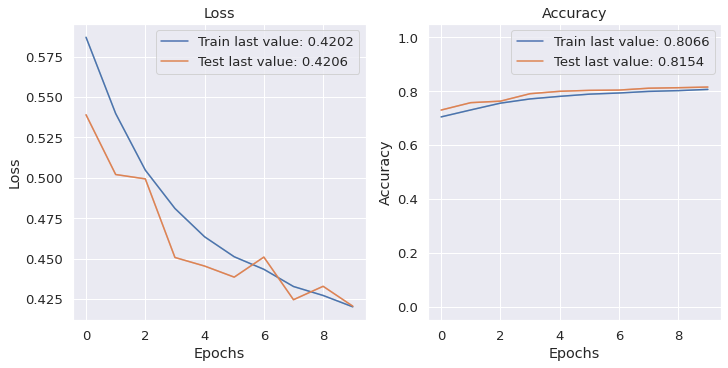

In [76]:


train_loss_in, train_accuracy_in = model_input_dp.evaluate(X_train, y_train1, verbose=True)
print("Training Accuracy: {:.4f}".format(train_accuracy_in))
print("Train Loss: {:.4f}".format(train_loss_in))

test_loss_in, test_accuracy_in = model_input_dp.evaluate(X_test, y_test1, verbose=True)
print("Testing Accuracy:  {:.4f}".format(test_accuracy_in))
print("Test Loss:  {:.4f}".format(test_loss_in))

plot_history(hist_inp_dp)

####  BI-LSTM model with Recurrent Dropout

In [77]:
#Define the BiLSTM model with recurrent Dropout
##############################################

model_rec_dp = Sequential()
model_rec_dp.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
model_rec_dp.add(Bidirectional(LSTM(64,recurrent_dropout=0.5)))
#output Dropout
model_rec_dp.add(Dropout(0.5))
model_rec_dp.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model_rec_dp.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
model_rec_dp.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          3082800   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 128)               84480     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 3,167,409
Trainable params: 84,609
Non-trainable params: 3,082,800
_________________________________________________________________


In [79]:

#Train the model
batch_size = 512
#tf.config.run_functions_eagerly(True)

print('Train...')
hist_rec_dp = model_rec_dp.fit(X_train, y_train,
          batch_size=1024,
          epochs=10,validation_data=(X_test, y_test)).history

Train...
Epoch 1/10
139/139 [==============================] - 406s 3s/step - loss: 0.5683 - accuracy: 0.7164 - val_loss: 0.5181 - val_accuracy: 0.7441
Epoch 2/10
139/139 [==============================] - 405s 3s/step - loss: 0.5028 - accuracy: 0.7574 - val_loss: 0.4760 - val_accuracy: 0.7756
Epoch 3/10
139/139 [==============================] - 407s 3s/step - loss: 0.4700 - accuracy: 0.7805 - val_loss: 0.4487 - val_accuracy: 0.7932
Epoch 4/10
139/139 [==============================] - 406s 3s/step - loss: 0.4452 - accuracy: 0.7955 - val_loss: 0.4283 - val_accuracy: 0.8050
Epoch 5/10
139/139 [==============================] - 404s 3s/step - loss: 0.4299 - accuracy: 0.8034 - val_loss: 0.4246 - val_accuracy: 0.8105
Epoch 6/10
139/139 [==============================] - 402s 3s/step - loss: 0.4185 - accuracy: 0.8106 - val_loss: 0.4262 - val_accuracy: 0.8097
Epoch 7/10
139/139 [==============================] - 402s 3s/step - loss: 0.4077 - accuracy: 0.8161 - val_loss: 0.3985 - val_accurac

4440/4440 [==============================] - 162s 36ms/step - loss: 0.3588 - accuracy: 0.8413
Training Accuracy: 0.8413
Train Loss: 0.3588
2187/2187 [==============================] - 80s 37ms/step - loss: 0.3839 - accuracy: 0.8298
Testing Accuracy:  0.8298
Test Loss:  0.3839


(<Figure size 720x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1b4ffc9b50>,
       dtype=object))

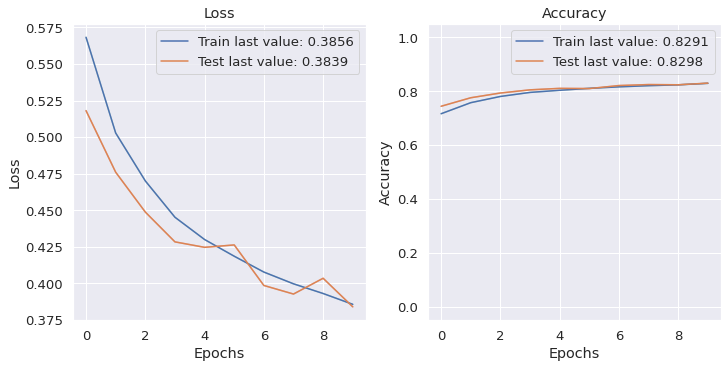

In [80]:

train_loss_rec, train_accuracy_rec = model_rec_dp.evaluate(X_train, y_train1, verbose=True)
print("Training Accuracy: {:.4f}".format(train_accuracy_rec))
print("Train Loss: {:.4f}".format(train_loss_rec))

test_loss_rec, test_accuracy_rec = model_rec_dp.evaluate(X_test, y_test1, verbose=True)
print("Testing Accuracy:  {:.4f}".format(test_accuracy_rec))
print("Test Loss:  {:.4f}".format(test_loss_rec))


plot_history(hist_rec_dp)

In [82]:
sub_preds_deep1 = model_out_dp.predict(y_test,batch_size=1024)
#print(sub_preds_deep1)
df_test['deep_pred'] = sub_preds_deep1

##### Extract Predictions

In [85]:
df_test1 = df_test.groupby(['condition','drugName']).agg({'deep_pred' : 'sum'})
df_test1.to_csv('final_drug.csv')
df_test2=df_test1.sort_values('deep_pred',ascending=False).groupby(['drugName']).head(5)
df_test2.to_csv('final_drugg.csv')

In [86]:
df_test

uniqueID                          drugName  \
147354    126702                       Brimonidine   
195249     84765  Ethinyl estradiol / norgestimate   
86265      71559                           Vraylar   
44172     132320                            Ativan   
90569     177278                        Duloxetine   
...          ...                               ...   
127553    216906                       Lifitegrast   
45442     141240                      Escitalopram   
148240     54801            Bupropion / naltrexone   
175071    101255                             Aubra   
200011     26484                          Sprintec   

                          condition  \
147354                      Rosacea   
195249                Birth Control   
86265               Bipolar Disorde   
44172                       Anxiety   
90569   Generalized Anxiety Disorde   
...                             ...   
127553              Dry Eye Disease   
45442                    Depression   
148240                  Weight Loss   
175071                Birth Control   
200011    Abnormal Uterine Bleeding   

                                                   review  rating       date  \
147354  "Never , never , never use this cream !!!!!! I...       1 2015-08-31   
195249  "I was switched to this after about 9 months o...      10 2016-05-01   
86265   "I began at 1.5 then titrated to 3mg dosage. A...       3 2016-08-17   
44172   "Ativan 0.5mg calms me down considerably withi...       5 2012-01-12   
90569   "My thoughts on Cymbalta: Cymbalta has left me...       1 2017-05-03   
...                                                   ...     ...        ...   
127553  "I had no initial problems with Xiidra. No bur...       1 2017-04-01   
45442   "Started out with 10 mg, stuck with it for pro...       7 2015-05-12   
148240  "I took the medicine for 2 weeks by taking 1 i...       1 2017-02-24   
175071  "This is my first birth control ever and I rea...      10 2017-06-30   
200011  "I&#039;ve been taking it for 2 months with no...      10 2014-10-20   

        usefulCount                                       review_clean  \
147354           17  never never never use cream help way angri dis...   
195249            3  switch month mononessa ask switch happen anywa...   
86265            17  began titrat mg dosag first love medicin compl...   
44172            26  ativan mg calm consider within minut side effe...   
90569            29  thought cymbalta cymbalta left fog no feel non...   
...             ...                                                ...   
127553           49  no initi problem xiidra no burn bad tast seem ...   
45442             8  start mg stuck probabl month entir time feel s...   
148240            7  took medicin week take morn anoth one night lo...   
175071            0  first birth control ever realli love use horri...   
200011            8             take month no issu also cramp not pain   

        sentiment  deep_pred  
147354          0   0.529552  
195249          1   0.490782  
86265           0   0.529552  
44172           0   0.529552  
90569           0   0.529552  
...           ...        ...  
127553          0   0.529552  
45442           1   0.490782  
148240          0   0.529552  
175071          1   0.490782  
200011          1   0.490782  

[69978 rows x 10 columns]

In [90]:
import sense2vec
from sense2vec import Sense2VecComponent
len(w2v_model.wv.vocab)


8517

In [98]:
#### Side Effect Analysis
def sideEffectAnalysis(condition):
    df_all_Pain=df_train[df_train['condition']==condition]
    df_valid=df_all_Pain[df_all_Pain.astype(str)['side_effect'] != '[]']
    df_drug_count_all=df_all_Pain.groupby('drugName')['side_effect'].count().reset_index(name='count')
    df_drug_count_valid=df_valid.groupby('drugName')['side_effect'].count().reset_index(name='count')
    df_drug_count_bind=pd.merge(df_drug_count_all,df_drug_count_valid,how='left',on=['drugName'])
    df_drug_count_bind['percentage']=df_drug_count_bind['count_y']/df_drug_count_bind['count_x']
    df_drug_count_bind.percentage.fillna(value=0, inplace=True)
    df_drug_count_bind=df_drug_count_bind.sort_values('percentage',ascending=False)
    ax=df_drug_count_bind[0:20].plot(kind="bar", figsize = (14,6), fontsize = 10,color="#31b0c1",x='drugName',y='percentage', legend=None)
    plt.xlabel("", fontsize = 20)
    plt.ylabel("", fontsize = 20)
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
    plt.title("Percentage of Side Effect Occurrence for "+condition, fontsize = 20)
    
    df_all_Pain_group=df_all_Pain.groupby('drugName')['side_effect'].apply(sum).reset_index(name='side_effect')
    df_all_Pain_noSide=df_all_Pain_group[df_all_Pain_group.astype(str)['side_effect'] == '[]']['drugName']
    print('----------Medicine with no side effects mentioned: '+condition+'----------')
    print(df_all_Pain_noSide.values)
    side_effect_list_pain=df_all_Pain_group[df_all_Pain_group.astype(str)['side_effect'] != '[]']['side_effect'].values
    #print(side_effect_list_pain)
    side_effect_list_str_pain=[c for l in side_effect_list_pain for c in l]
    print('----------Top Frequent Side Effect for: '+condition+'----------')
    side_effect_list_str_pain_frequency=FreqDist(side_effect_list_str_pain).most_common(20)
    print(side_effect_list_str_pain)
    side_effect_list_str_pain_text=" ".join(side_effect_list_str_pain)
    print('side_effect_list_str_pain_text',side_effect_list_str_pain_text)
    plot_wordcloud(side_effect_list_str_pain_text, title="Word Cloud of side effect: "+condition)
    df_pain_with_side_effect=df_all_Pain_group[df_all_Pain_group.astype(str)['side_effect'] != '[]']
    df_pain_with_side_effect['count']=df_pain_with_side_effect['side_effect'].str.len()
    df_pain_with_side_effect=df_pain_with_side_effect.sort_values('count',ascending=False)
    df_pain_with_side_effect[0:20].plot(kind="bar", figsize = (14,6), fontsize = 10,color="#31b0c1",x='drugName',y='count')
    plt.xlabel("", fontsize = 20)
    plt.ylabel("", fontsize = 20)
    plt.title("Count of side effect reviews for "+condition, fontsize = 20)

### TRANSFORMER

In [78]:
!pip install torch

In [79]:
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch import tensor
from torch import optim

import matplotlib.pyplot as plt

torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'


# XOR gate inputs and outputs.
X = xor_input = tensor([[0,0], [0,1], [1,0], [1,1]]).float().to(device)
Y = xor_output = tensor([[0],[1],[1],[0]]).float().to(device)

# Use tensor.shape to get the shape of the matrix/tensor.
num_data, input_dim = X.shape
print('Inputs Dim:', input_dim) # i.e. n=2 

num_data, output_dim = Y.shape
print('Output Dim:', output_dim) 
print('No. of Data:', num_data) # i.e. n=4
print(Y)

Inputs Dim: 2
Output Dim: 1
No. of Data: 4
tensor([[0.],
        [1.],
        [1.],
        [0.]], device='cuda:0')


In [80]:
y_train1=y_train.to_numpy()

In [81]:
y_train1=y_train1.reshape(142075,1)

In [82]:

X = torch.from_numpy(X_train).float().to(device)
Y = torch.from_numpy(y_train1).float().to(device)
print(X.shape,Y.shape)
# Use tensor.shape to get the shape of the matrix/tensor.
num_data, input_dim = X.shape
print('Inputs Dim:', input_dim) # i.e. n=2 

num_data, output_dim = Y.shape
print('Output Dim:', output_dim) 
print('No. of Data:', num_data) # i.e. n=4

print(Y)

torch.Size([142075, 100]) torch.Size([142075, 1])
Inputs Dim: 100
Output Dim: 1
No. of Data: 142075
tensor([[1.],
        [1.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]], device='cuda:0')


100%|██████████| 50/50 [00:00<00:00, 435.55it/s]


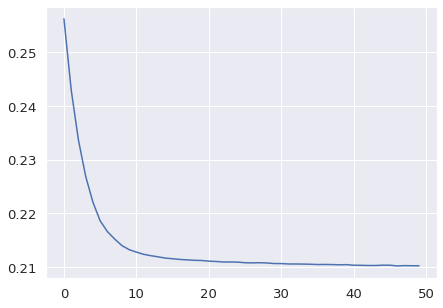

In [83]:
# Step 1: Initialization. 

# Initialize the model.
# Set the hidden dimension size.
hidden_dim = 10
# Use Sequential to define a simple feed-forward network.
model = nn.Sequential(
            # Use nn.Linear to get our simple perceptron.
            nn.Linear(input_dim, hidden_dim),
            # Use nn.Sigmoid to get our sigmoid non-linearity.
            nn.Sigmoid(),
            # Second layer neurons.
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        ).to(device)

# Initialize the optimizer
learning_rate = 0.3
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Initialize the loss function.
criterion = nn.MSELoss()

# Initialize the stopping criteria
# For simplicity, just stop training after certain no. of epochs.
num_epochs = 50

losses = [] # Keeps track of the loses.

# Step 2-4 of training routine.

for _e in tqdm(range(num_epochs)):
    # Reset the gradient after every epoch. 
    optimizer.zero_grad() 
    # Step 2: Foward Propagation
    predictions = model(X)
    
    # Step 3: Back Propagation 
    # Calculate the cost between the predictions and the truth.
    loss = criterion(predictions, Y)
    # Remember to back propagate the loss you've computed above.
    loss.backward()
    
    # Step 4: Optimizer take a step and update the weights.
    optimizer.step()
    
    # Log the loss value as we proceed through the epochs.
    losses.append(loss.data.item())
    

plt.plot(losses)

In [84]:
!pip install transformers

#### BERT Model

In [85]:
import torch
from transformers import BertTokenizer,GPT2Tokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer1 = GPT2Tokenizer.from_pretrained('gpt2', do_lower_case=True)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [86]:
sentences=df_train['review_clean'].to_numpy()
labels=y_train1#df_train['sentiment'].to_numpy()

In [87]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    input_ids1 = tokenizer1.encode(sent, add_special_tokens=True)
    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))
    max_len1 = max(max_len, len(input_ids1))

print('Max sentence length: ', max_len)
print('Max sentence length: ', max_len1)

Token indices sequence length is longer than the specified maximum sequence length for this model (770 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  770
Max sentence length:  770


In [88]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
attention_masks1 = []
input_ids1 = []
# For every sentence...
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        padding = 'max_length',
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    encoded_dict1 = tokenizer1.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 774,           # Pad & truncate all sentences.
                        #padding = 'max_length',
                        #pad_to_max_length = True,
                        #truncation=True,
                        #return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    input_ids1.append(encoded_dict1['input_ids'])
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])
    attention_masks1.append(encoded_dict1['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)


attention_masks = torch.cat(attention_masks, dim=0)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [89]:
labels = torch.tensor(labels)

In [90]:
# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])
print('Attention masks:', attention_masks[0])
print(input_ids.shape,attention_masks.shape,labels.shape)


Original:  tri near everi ssri market place pristiq improv condit somewhat still left depend xanax allevi daili anxieti particular bad stretch also place seroquel xr help could ever hope final reach xanax soon wake sedat first week start increas dosag lessen time make sure take bed make tire kick welcom due problem insomnia
Token IDs: tensor([  101, 13012,  2379,  2412,  2072, 20896,  2072,  3006,  2173, 26927,
        16643,  4160, 17727, 12298,  9530, 23194,  5399,  2145,  2187, 12530,
         1060,  5162,  2595,  2035,  6777,  2072, 26181,  2072,  2019, 16898,
         3775,  3327,  2919,  7683,  2036,  2173, 14262,  2080, 22197,  1060,
         2099,  2393,  2071,  2412,  3246,  2345,  3362,  1060,  5162,  2595,
         2574,  5256,  7367,  2850,  2102,  2034,  2733,  2707,  4297, 16416,
         2015,  9998,  8490,   102])
Attention masks: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [91]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)
# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))

val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))



127,867 training samples
14,208 validation samples


In [92]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )



In [99]:
from transformers import BertForSequenceClassification, AdamW, BertConfig,GPT2ForSequenceClassification

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model.cuda()

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()


model1 = GPT2ForSequenceClassification.from_pretrained("gpt2",   
                                                       num_labels = 2, # The number of output labels--2 for binary classification.
                                                                        # You can increase this for multi-class tasks.   
                                                        output_attentions = False, # Whether the model returns attentions weights.
                                                        output_hidden_states = False)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [101]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

optimizer1 = AdamW(model1.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [102]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

print(total_steps)

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

scheduler1 = get_linear_schedule_with_warmup(optimizer1, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

15984


In [103]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [104]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

In [105]:
# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()


# For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 400 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        


        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += outputs.loss.item()

        # Perform a backward pass to calculate the gradients.
        outputs.loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            outputs = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += outputs.loss.item()

        # Move logits and labels to CPU
        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))  


======== Epoch 1 / 4 ========
Training...
  Batch   400  of  3,996.    Elapsed: 0:02:34.
  Batch   800  of  3,996.    Elapsed: 0:05:07.
  Batch 1,200  of  3,996.    Elapsed: 0:07:40.
  Batch 1,600  of  3,996.    Elapsed: 0:10:13.
  Batch 2,000  of  3,996.    Elapsed: 0:12:46.
  Batch 2,400  of  3,996.    Elapsed: 0:15:19.
  Batch 2,800  of  3,996.    Elapsed: 0:17:51.
  Batch 3,200  of  3,996.    Elapsed: 0:20:24.
  Batch 3,600  of  3,996.    Elapsed: 0:22:57.

  Average training loss: 0.40
  Training epcoh took: 0:25:28

Running Validation...
  Accuracy: 0.86
  Validation Loss: 0.33
  Validation took: 0:00:56

======== Epoch 2 / 4 ========
Training...
  Batch   400  of  3,996.    Elapsed: 0:02:33.
  Batch   800  of  3,996.    Elapsed: 0:05:06.
  Batch 1,200  of  3,996.    Elapsed: 0:07:39.
  Batch 1,600  of  3,996.    Elapsed: 0:10:12.
  Batch 2,000  of  3,996.    Elapsed: 0:12:44.
  Batch 2,400  of  3,996.    Elapsed: 0:15:17.
  Batch 2,800  of  3,996.    Elapsed: 0:17:50.
  Batch 3

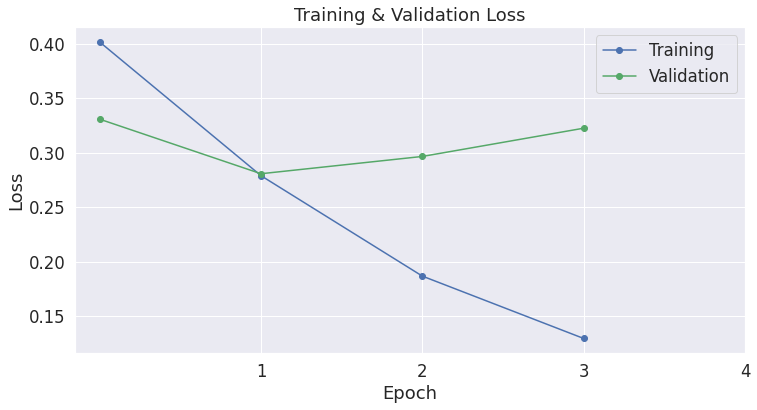

In [106]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

df_stats = pd.DataFrame(data=training_stats)

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [107]:
import pandas as pd

y_test1=y_test.to_numpy()
y_test1=y_test1.reshape(69978,1)
# Create sentence and label lists
sentences_test = df_test['review_clean']
labels_test = y_test1

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences_test:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels_test = torch.tensor(labels_test)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels_test)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [108]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 69,978 test sentences...
    DONE.


In [109]:
total_test_accuracy = 0
for p, t in zip(predictions, true_labels):
  print("Accuracy for batch: ", flat_accuracy(p, t))
  total_test_accuracy += flat_accuracy(p, t)

print("Overall accuracy for test set:", total_test_accuracy/len(predictions))



Accuracy for batch:  0.90625
Accuracy for batch:  0.96875
Accuracy for batch:  0.9375
Accuracy for batch:  0.9375
Accuracy for batch:  0.9375
Accuracy for batch:  0.90625
Accuracy for batch:  0.96875
Accuracy for batch:  0.96875
Accuracy for batch:  0.84375
Accuracy for batch:  0.84375
Accuracy for batch:  0.96875
Accuracy for batch:  0.90625
Accuracy for batch:  0.9375
Accuracy for batch:  0.9375
Accuracy for batch:  0.9375
Accuracy for batch:  0.875
Accuracy for batch:  0.9375
Accuracy for batch:  0.90625
Accuracy for batch:  0.90625
Accuracy for batch:  0.90625
Accuracy for batch:  0.90625
Accuracy for batch:  0.875
Accuracy for batch:  0.875
Accuracy for batch:  0.96875
Accuracy for batch:  0.9375
Accuracy for batch:  0.84375
Accuracy for batch:  0.96875
Accuracy for batch:  0.84375
Accuracy for batch:  0.875
Accuracy for batch:  0.9375
Accuracy for batch:  0.84375
Accuracy for batch:  0.875
Accuracy for batch:  0.9375
Accuracy for batch:  0.84375
Accuracy for batch:  0.84375
Accur

In [110]:
print('Positive samples: %d of %d (%.2f%%)' % (df_test.sentiment.sum(), len(df_test.sentiment), (df_test.sentiment.sum() / len(df_test.sentiment) * 100.0)))

for t in true_labels:
  print('Positive samples in batch: %d of %d (%.2f%%)' % (t.sum(), len(t), (t.sum() / len(t) * 100.0)))

Positive samples: 48969 of 69978 (69.98%)
Positive samples in batch: 22 of 32 (68.75%)
Positive samples in batch: 24 of 32 (75.00%)
Positive samples in batch: 23 of 32 (71.88%)
Positive samples in batch: 26 of 32 (81.25%)
Positive samples in batch: 27 of 32 (84.38%)
Positive samples in batch: 23 of 32 (71.88%)
Positive samples in batch: 24 of 32 (75.00%)
Positive samples in batch: 24 of 32 (75.00%)
Positive samples in batch: 25 of 32 (78.12%)
Positive samples in batch: 22 of 32 (68.75%)
Positive samples in batch: 24 of 32 (75.00%)
Positive samples in batch: 24 of 32 (75.00%)
Positive samples in batch: 23 of 32 (71.88%)
Positive samples in batch: 25 of 32 (78.12%)
Positive samples in batch: 24 of 32 (75.00%)
Positive samples in batch: 23 of 32 (71.88%)
Positive samples in batch: 23 of 32 (71.88%)
Positive samples in batch: 26 of 32 (81.25%)
Positive samples in batch: 23 of 32 (71.88%)
Positive samples in batch: 25 of 32 (78.12%)
Positive samples in batch: 23 of 32 (71.88%)
Positive samp

Calculating Matthews Corr. Coef. for each batch...


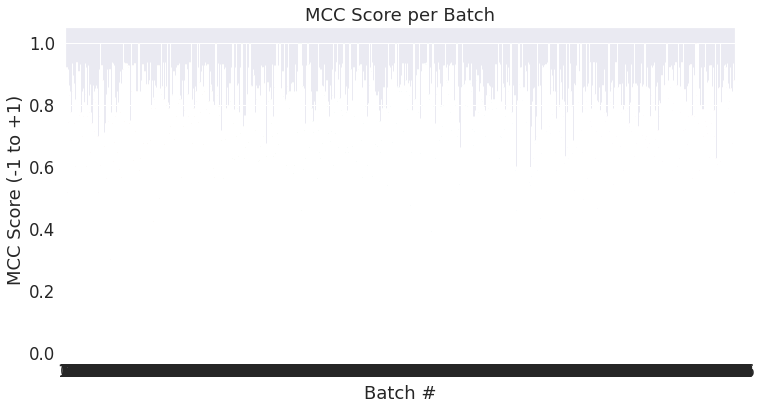

In [111]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []
pred_labels = []
# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch, convert the predicted logits to 0/1 labels...
for i in range(len(predictions)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels.append(np.argmax(predictions[i], axis=1).flatten())
  

# For each input batch...
for i in range(len(true_labels)):

  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels[i])                
  matthews_set.append(matthews)



# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [112]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_pred_labels = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_pred_labels)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.766


In [ ]:
#Saving your model.
output_file = "./model_bert_ft_drug.pth"

def save(model, optimizer):
    # save
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, output_file)

save(model, optimizer)

In [ ]:
#In the future, if you want to continue to work on this model, you can load it back in.
checkpoint = torch.load(output_file, map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

## Topic Modeling

In [26]:
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [28]:
count_vectorizer = CountVectorizer()
count_data = count_vectorizer.fit_transform(df_all[df_all.condition=='Birth Control'].review)

number_topics = 3
number_words = 8

lda = LDA(n_components=number_topics, n_jobs=-1, random_state=1)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
the it and was to my had 039

Topic #1:
039 it and the my have for to

Topic #2:
and the my to it was this on


In [30]:
count_data = count_vectorizer.fit_transform(df_test[df_test.condition=='Depression'].review)

number_topics = 3
number_words = 8

lda = LDA(n_components=number_topics, n_jobs=-1, random_state=55566)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
and to the my was of in for

Topic #1:
and the 039 it have is of to

Topic #2:
and the it to 039 for my was


## Entity Extraction - Training SpaCy NER for DRUG

In [35]:
drug_list = df_train['drugName'].value_counts().index.tolist()
drug_list = [x.lower() for x in drug_list]

In [32]:
#First let's check some NERs in first 10 reviews and remove date, time, ordinal and cardinal.
import spacy
nlp = spacy.load('en_core_web_sm')
count = 0
for review in df_train['review']:
    if count < 11:
        doc = nlp(review)
        ents = [(e.text, e.label_) for e in doc.ents if e.label_ not in ('DATE', 'TIME', 'ORDINAL', 'CARDINAL')]
        print(ents)
    count += 1

[]
[]
[('US', 'GPE'), ('Lybrel', 'GPE'), ('Lybrel', 'PERSON')]
[]
[('Suboxone', 'GPE'), ('you&#039;re', 'PERSON')]
[('&amp', 'ORG'), ('Leg', 'PERSON'), ('2', 'MONEY'), ('230', 'MONEY')]
[('the Plan B 26 hours later', 'LAW')]
[('Zoloft', 'PERSON'), ('Clonidine', 'PERSON'), ('Abilify', 'FAC'), ('2mg', 'QUANTITY')]
[('Ve', 'PERSON'), ('Keppera', 'PERSON'), ('legs &amp', 'ORG'), ('pins &amp', 'ORG'), ('needles', 'NORP')]
[('RX', 'ORG')]
[]


In [33]:
def process_review(review):
    processed_token = []
    for token in review.split():
        token = ''.join(e.lower() for e in token if e.isalnum())
        processed_token.append(token)
    return ' '.join(processed_token)

In [37]:
#Step 1: Let's create the training data

TRAIN_DATA = []
for _, item in df_train.iterrows():
    ent_dict = {}
    if count < 1000:
        review = process_review(item['review'])
        #We will find a drug and its positions once and add to the visited items.
        visited_items = []
        entities = []
        for token in review.split():
            if token in drug_list:
                for i in re.finditer(token, review):
                    if token not in visited_items:
                        entity = (i.span()[0], i.span()[1], 'DRUG')
                        visited_items.append(token)
                        entities.append(entity)
        if len(entities) > 0:
            ent_dict['entities'] = entities
            train_item = (review, ent_dict)
            TRAIN_DATA.append(train_item)
            count+=1

In [38]:
n_iter = 10
def train():
    nlp = spacy.blank("en")  # create blank Language class
    print("Created blank 'en' model")
    
    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe(ner, last=True)
    # otherwise, get it so we can add labels
    else:
        ner = nlp.get_pipe("ner")
        
    # add labels
    for _, annotations in TRAIN_DATA:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])
            
    nlp.begin_training()
    for itn in range(n_iter):
        random.shuffle(TRAIN_DATA)
        losses = {}
        # batch up the examples using spaCy's minibatch
        batches = minibatch(TRAIN_DATA, size=compounding(4.0, 32.0, 1.001))
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(
                texts,  # batch of texts
                annotations,  # batch of annotations
                drop=0.5,  # dropout - make it harder to memorise data
                losses=losses,
            )
        print("Losses", losses)
    return nlp

In [41]:
import re
import random
from spacy.util import minibatch, compounding
nlp2 = train()

Created blank 'en' model
Losses {'ner': 4299.116004584463}
Losses {'ner': 1347.8104322831016}
Losses {'ner': 1007.712584618643}
Losses {'ner': 819.0609154626615}
Losses {'ner': 729.9794915168682}
Losses {'ner': 660.484819652189}
Losses {'ner': 624.2469579386138}
Losses {'ner': 560.0412045577842}
Losses {'ner': 507.35031412941845}
Losses {'ner': 500.6310226320269}


In [42]:
for text, _ in TRAIN_DATA[:10]:
    doc = nlp2(text)
    print("Entities", [(ent.text, ent.label_) for ent in doc.ents])

Entities [('implanon', 'DRUG')]
Entities [('oxycontin', 'DRUG')]
Entities [('alli', 'DRUG')]
Entities [('paliperidone', 'DRUG'), ('clozapine', 'DRUG')]
Entities [('zofran', 'DRUG')]
Entities [('amoxicillin', 'DRUG'), ('erythromycin', 'DRUG')]
Entities [('clonazepam', 'DRUG')]
Entities [('implanon', 'DRUG')]
Entities [('clindamycin', 'DRUG')]
Entities [('paxil', 'DRUG'), ('lexapro', 'DRUG'), ('buspirone', 'DRUG')]


In [43]:
test_reviews = df_train.iloc[-10:, :]['review']
for review in test_reviews:
    review = process_review(review)
    print(review)
    doc = nlp2(review)
    print("Entities", [(ent.text, ent.label_) for ent in doc.ents])
    print('________________________')

i was super against taking medication i039ve started dealing with anxiety some depression for awhile now i got prescribed ativan months ago and never took it i thought i could handle myself again but then my relationship started to fail because of my over thinking i went back to the doctor and decided to try it she prescribed me 50 3 times a day i took a full one at night after a bad panic attack and within 30 minutes i was calm and slept through the entire night i have only been taking a half morning and mid afternoon and full at night because it does make you feel tired my brain is in a slight fog but nothing crazy i still know whats going on though  give it a try if you are suffering you will know after 1
Entities [('ativan', 'DRUG')]
________________________
i have been off prozac for about 4 weeks nowafter starting 2 years ago for a terrible depressionsadnessmenopause wanted to take a holiday to see what would happen when on prozac side effects like decrease sexual drive and sligh